In [1]:
#Load up names.txt
words = open('names.txt', 'r').read().split('\n')

In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import plotly.graph_objs as go

In [3]:
#Get a list of all the chars
chars = ['.'] + sorted(list(set(''.join(words))))

#Tokenize the text- This will be used to convert the text to numbers
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

In [4]:
#Build data set
block_size = 3

def build_data_set(words):
    #Get the inputs and targets
    X, Y = [], []

    for word in words[:]:
        word = "." + word + "."
        context = [0] * block_size
        for i in range(len(word)-1):
            chr = char_to_idx[word[i]]
            context.append(chr)
            if len(context) > block_size:
                context = context[1:]
            X.append(context[:])
            Y.append(char_to_idx[word[i+1]])

            # print("For context", context, "predict", word[i+1])

    #Convert to tensor
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

import random
random.seed(42)

#Shuffle the data
random.shuffle(words)

n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

X_train, Y_train = build_data_set(words[:n1])
X, Y = build_data_set(words[:n1]) #Just for prev code
X_val, Y_val = build_data_set(words[n1:n2])
X_test, Y_test = build_data_set(words[n2:])
print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))


Train: 182625 Val: 22655 Test: 22866


In [39]:
emb_dim = 10
hidden_size = 200
batch_size = 32 
n = 10000

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn(len(chars), emb_dim, generator=g)
W1 = torch.randn(emb_dim*block_size, hidden_size, generator=g) * (5/3)/np.sqrt(emb_dim*block_size)
# b1 = torch.randn(hidden_size, generator=g) * .01
W2 = torch.randn(hidden_size, len(chars), generator=g)*0.01
b2 = torch.randn(len(chars), generator=g)*0

bngain = torch.ones((1, hidden_size))
bnbias = torch.zeros((1,hidden_size))

bnmean_running = torch.ones((1, hidden_size))
bnstd_running = torch.zeros((1,hidden_size))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad_()



In [40]:
n = 10000
batch_size = 32
lr = .001

In [41]:
#Print mean and stddev of hpreact 
mean = hpreact.mean(0)[0].item()
stddev = hpreact.std(0)[0].item()
print("Mean:", mean, "Stddev:", stddev)

Mean: -0.504972517490387 Stddev: 1.6841644048690796


In [55]:
for i in range(n):
    #Mini-batch
    ix = torch.randint(len(X_train), (batch_size,))

    emb = C[X_train[ix]]
    emb = emb.view(len(X_train[ix]), -1) #len(X_train) x (block_size*2)
    hpreact = emb @ W1
    #Batch norm
    mean = hpreact.mean(0, keepdim=True)
    var = hpreact.var(0, keepdim=True)
    hpreact = (hpreact - mean) / torch.sqrt(var + 1e-8)
    hpreact = hpreact * bngain + bnbias

    #Now update the running mean and stddev to move in the direction of the batch's mean and stddev
    with torch.no_grad():
        bnmean_running = .9 * bnmean_running + .1 * mean
        bnstd_running = .9 * bnstd_running + .1 * var

    h = torch.tanh(hpreact) #Apply activation function
    logits = h @ W2 + b2 #len(X_train) x len(chars)
    loss = F.cross_entropy(logits, Y[ix]) #This is the same as the above 4 lines 
    

    #Backward Pass
    for p in parameters:
        p.grad = None

    loss.backward()

    #Update parameters
    #Disable gradient tracking (for efficiency)
    with torch.no_grad():
        for p in parameters:
            p.data -= lr * p.grad





In [56]:
#Calculate batch norm after training
emb = C[X_train]
emb = emb.view(len(X_train), -1) #len(X_train) x (block_size*2)
hpreact = emb @ W1 #+ b1
#Batch norm
mean = hpreact.mean(0, keepdim=True)
var = hpreact.var(0, keepdim=True)

#Print mean and stddev of hpreact and compare to the batch norm running mean and stddev
mean = hpreact.mean(0)[0].item()
stddev = hpreact.std(0)[0].item()
print("Method 1 Mean:", mean, "Stddev:", stddev)
print("Method 2 Mean:", bnmean_running[0][0].item(), "Stddev:", torch.sqrt(bnstd_running[0][0]).item())

#Print the percent difference between the two methods
print("Percent difference (Mean):", 100 * (mean - bnmean_running[0][0].item()) / bnmean_running[0][0].item())
print("Percent difference (Stddev):", 100 * (stddev - torch.sqrt(bnstd_running[0][0]).item()) / torch.sqrt(bnstd_running[0][0]).item())

Method 1 Mean: -0.5559956431388855 Stddev: 1.741192102432251
Method 2 Mean: -0.5310854315757751 Stddev: 1.6845917701721191
Percent difference (Mean): 4.690433983323485
Percent difference (Stddev): 3.3598841726710345


In [46]:
#Calculate loss of validation set
emb = C[X_val]
emb = emb.view(len(X_val), -1) #len(X_val) x (block_size*2)
hpreact = emb @ W1 #+ b1
#Batch norm
hpreact = (hpreact - bnmean_running) / torch.sqrt(bnstd_running + 1e-8)
hpreact = hpreact * bngain + bnbias
h = torch.tanh(hpreact) #Apply activation function
logits = h @ W2 + b2 #len(X_val) x len(chars)
loss = F.cross_entropy(logits, Y_val) #This is the same as the above 4 lines
print("Validation Loss: ", loss.item())

#Calculate loss of Training set
emb = C[X_train]
emb = emb.view(len(X_train), -1) #len(X_train) x (block_size*2)
h = emb @ W1 #+ b1 #len(X_train) x hidden_size
h = torch.tanh(h) #Apply activation function
logits = h @ W2 + b2 #len(X_train) x len(chars)
loss = F.cross_entropy(logits, Y_train) #This is the same as the above 4 lines
print("Training Loss: ", loss.item()) 

#Training Loss is close to Validation Loss so we are not overfitting. 

Validation Loss:  2.67166805267334
Training Loss:  2.729121208190918


In [9]:
#Mini-batch
ix = torch.randint(len(X_train), (batch_size,))

emb = C[X_train[ix]]
emb = emb.view(len(X_train[ix]), -1) #len(X_train) x (block_size*2)
h = emb @ W1 #+ b1 #len(X_train) x hidden_size
h = torch.tanh(h) #Apply activation function

#Plot histogram of h values
h = h.detach().numpy().flatten()

fig = go.Figure(data=[go.Histogram(x=h)])
fig.show()

In [10]:
x = torch.randn(1000,10)
w = torch.randn(10,200)/10**.5
y = x @ w

#Print mean and standard deviation of x compared to y (2 decimal places)
print("x mean:", round(x.mean().item(),2), "std:", round(x.std().item(),2))
print("y mean:", round(y.mean().item(),2), "std:", round(y.std().item(),2))

x mean: -0.01 std: 1.0
y mean: 0.0 std: 1.0


## Pytorchifying the code

In [88]:
#Create a Linear Layer Class
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn(fan_in, fan_out) / fan_in**.5
        self.bias = torch.zeros(fan_out) if bias else None
        self.params = [self.weight] + ([self.bias] if bias else [])

    def __call__(self, x):
        self.out = x @ self.weight 
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return self.params

#Create a Linear Layer Class to test
linear = Linear(10, 200, False)

x = torch.randn(1000,10)
y = linear(x)

In [81]:
#Creating the Batch Normalization Layer 
class BatchNorm1d: 
    def __init__(self,dim,eps=1e-5,momentum=.1):
        self.eps = eps
        self.momentum = momentum
        self.dim = dim
        self.gamma = torch.ones(dim) #Gain
        self.beta = torch.zeros(dim) #Bias
        self.params = [self.gamma,self.beta]
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

        self.training = True

    def __call__(self,x):
        #Calculate Forward Pass
        if self.training:
            #Use batch mean
            xmean = x.mean(dim=0, keepdim=True)
            xvar = x.var(dim=0, keepdim=True)
        else: 
            #Use running mean
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) #Make it a gaussian (mean 0, std 1)
        self.out = self.gamma * xhat + self.beta #Scale and shiftA

        #Update running mean and variance
        if self.training:
            with torch.no_grad():
                self.running_mean = self.momentum * xmean + (1 - self.momentum) * self.running_mean
                self.running_var = self.momentum * xvar + (1 - self.momentum) * self.running_var

        return self.out

    def parameters(self):
        return self.params 

In [82]:
class Tanh:
    def __init__(self):
        self.params = []

    def __call__(self, x):
        self.out = x.tanh()
        return self.out

    def parameters(self): 
        return self.params

In [180]:
#Convert the model to use the new layers

n_embd = 10 
n_hidden=  100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn(len(chars), n_embd, generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), #Remembers block size is the amount of context we are using
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, n_hidden, False),
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, n_hidden, False),
    BatchNorm1d(n_hidden),
    Tanh(),

    Linear(n_hidden, n_hidden, False),
    BatchNorm1d(n_hidden),
    Tanh(),
    
    Linear(n_hidden, len(chars)),
    BatchNorm1d(len(chars)),
]

#Change the initialization of the weights like we did before 
with torch.no_grad():
    #Last Layer should be initialized close to 0
    # layers[-1].weight *= 0.1
    # layers[-1].bias.zero_()
    layers[-1].gamma *= 0.1
    layers[-1].beta.zero_()

    #Apply Kaiming Initialization to all other layers
    for l in layers[:-1]:
        if isinstance(l, Linear):
            l.weight *= 5/3
    
#Get all the parameters of the model
parameters = [C] + [p for l in layers for p in l.parameters()]
for p in parameters:
    p.requires_grad = True

In [181]:
max_steps = 2000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    #Get the minibatch
    ix = torch.randint(len(X_train), (batch_size,), generator=g)
    x, y = X_train[ix], Y_train[ix]

    #Forward Pass
    #First embed the characters
    emb = C[x]
    x = emb.view(len(x), -1) #len(X_train) x (block_size*2)

    #Then pass through the layers
    for l in layers:
        x = l(x)
    loss = F.cross_entropy(x, y)


    #Backward Pass
    for l in layers:
        l.out.retain_grad() #Tell pytorch to keep the gradient of the output of the layer so we can use it later in our debugging
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = .1 if i < 150E3 else .01
    # lr = 1e-3
    for p in parameters:
        p.data -= lr * p.grad

    #Track stats every once in a while
    if i % 100 == 0:
        print(f'step: {i:5d}, loss: {loss.item():0.4f}')

    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters]) #Track the ratio of the gradient norm to the parameter norm

    
    lossi.append(loss.log10().item())

    # break


    

    


step:     0, loss: 3.3065
step:   100, loss: 2.9349
step:   200, loss: 2.7912
step:   300, loss: 2.5193
step:   400, loss: 2.7315
step:   500, loss: 2.3969
step:   600, loss: 2.2062
step:   700, loss: 2.4626
step:   800, loss: 2.4829
step:   900, loss: 2.2931
step:  1000, loss: 2.3450
step:  1100, loss: 2.4741
step:  1200, loss: 2.4618
step:  1300, loss: 2.3901
step:  1400, loss: 2.4290
step:  1500, loss: 2.4483
step:  1600, loss: 2.4641
step:  1700, loss: 2.4177
step:  1800, loss: 2.3293
step:  1900, loss: 2.4007


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 2.94%
layer 5 (      Tanh): mean -0.01, std 0.64, saturated: 2.97%
layer 8 (      Tanh): mean +0.01, std 0.66, saturated: 2.50%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 2.09%


Text(0.5, 1.0, 'activation distribution')

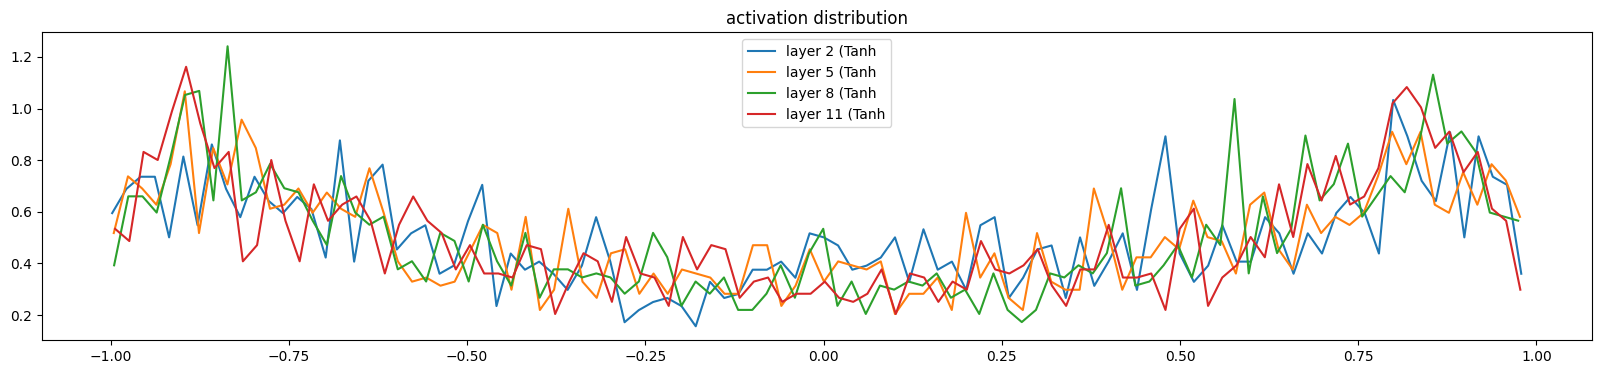

In [183]:
import matplotlib.pyplot as plt

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')


layer 1 (      Tanh): mean -0.000024, std 7.842590e-04
layer 3 (      Tanh): mean -0.000015, std 5.738824e-04
layer 5 (      Tanh): mean +0.000002, std 4.035204e-04
layer 7 (      Tanh): mean -0.000006, std 3.012999e-04


Text(0.5, 1.0, 'gradient distribution')

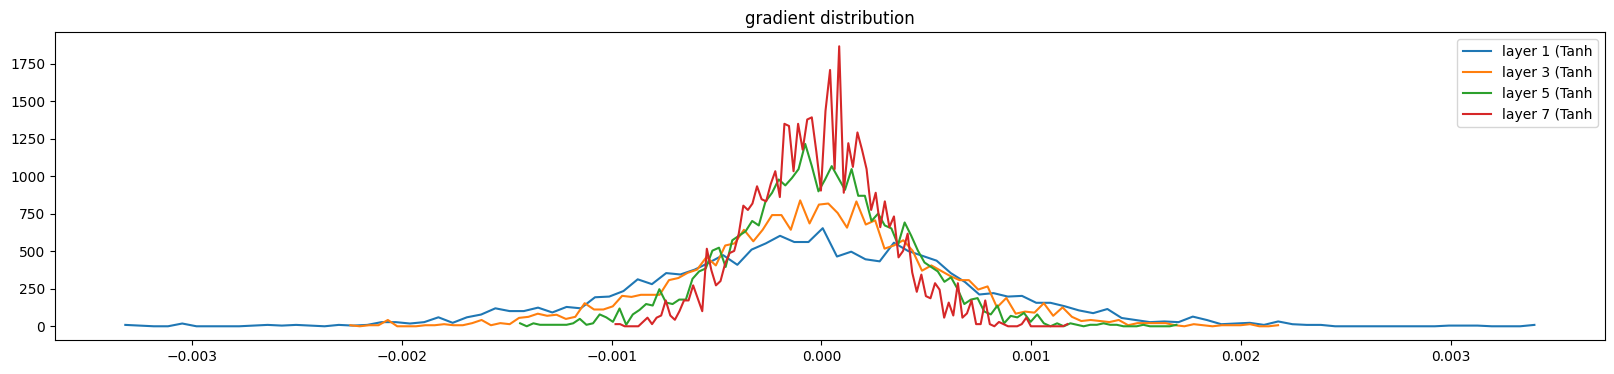

In [170]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')


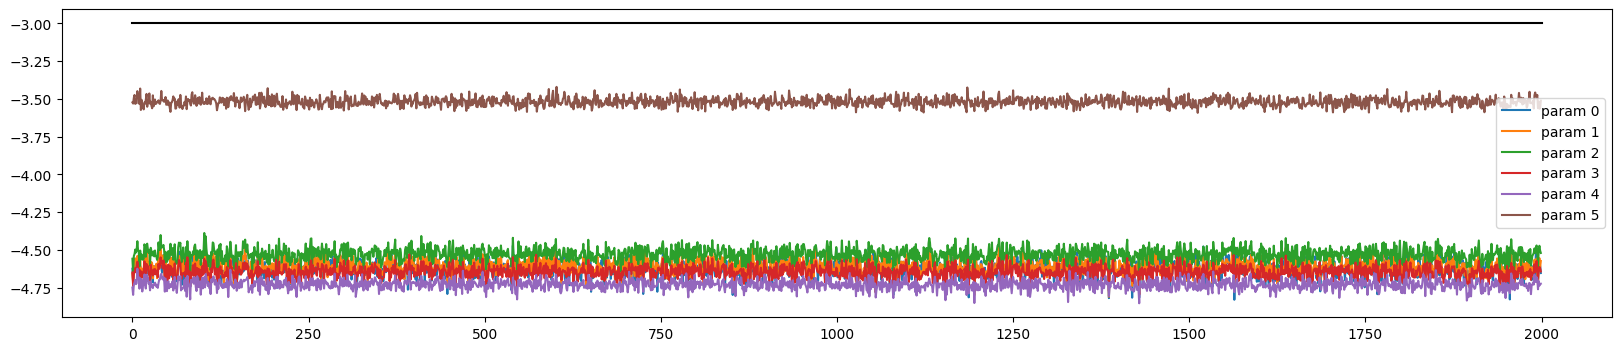

In [175]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [120]:
hy.shape

torch.Size([100])

In [118]:
hx.shape

torch.Size([101])

In [117]:
hx[:-1].detach().shape

torch.Size([100])

In [103]:
t.shape

torch.Size([32, 100])